# More intuitions for APT
I'm currently confusing myself about how exactly PyTorch applies matmuls in linear layers and the other operations in my APT stack with tensor splitting etc. The purpose of this NB is to trace these ops more carefully.

## Setup

In [ ]:
print('hello')

In [1]:
import torch
from torch.autograd.functional import hessian
from torch.nn import functional as F
import matplotlib as plt

import sys
sys.path.insert(0, '..')

from src.arithmetic_pretrained_transformer import APT, APTConfig, DataLoaderLite, DataLoaderPyTorch
from src.arithmetic_tokenizer import ArithmeticTokenizer


torch.set_printoptions(
    sci_mode=False, 
    threshold=10_000,
    edgeitems=3,
    )

device = "cuda:0"
model_file_id = "../apt_checkpoints/base/finalized_model_bos_is_False.pt"
state_dict = torch.load(model_file_id, weights_only=False, map_location=device)

loss_fn = F.cross_entropy

# we need x and y from somewhere

batch_size = 4096
vocab_path = '../tokenizer_variations/sum_0-9+special_vocab.json'
num_tokens_per_sample = 11
data_location = '../datasets/no_bos_no_eos/499by499.json'
tokenizer = ArithmeticTokenizer(vocab_path, max_length=num_tokens_per_sample, padding="max_length")

config = APTConfig(vocab_size=len(tokenizer._id_tokens),
                   block_size=num_tokens_per_sample,
                   n_layer=6,
                   n_head=1,
                   n_embd=3,
                   mlp_expansion_factor=32,
                   bias=True,
                   pos_embd='learned',
                   )
print(f"VOCAB SIZE IS {config.vocab_size}")
model = APT(config)
# now load state dict into model
model.load_state_dict(state_dict)
model = model.to(device)
model.device = device
model.tokenizer = tokenizer

using device cuda


/home/user/repos/APT/.apt_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VOCAB SIZE IS 17
Add different options for learned vs rotational vs alibi positional encodings!!!
Swap layernorm to RMSNorm!


In [2]:
from src.evaluation import eval_parallel_claude

train_loader = DataLoaderPyTorch(
    B=batch_size, 
    T=num_tokens_per_sample, 
    data_location=data_location, 
    tokenizer=tokenizer,
    eval_percentage=0.01,
    num_workers=0,
)

eval_prompts = []
eval_ground_truths = []
for elt in train_loader.eval_raw:
    eval_prompts.append(elt.split("=")[0] + "=")
    eval_ground_truths.append(elt)
    
em_score, acc_by_digits = eval_parallel_claude(model, eval_prompts, eval_ground_truths)

print(em_score)
print(acc_by_digits)

we have self.trainset_size 247500, and num_eval 2500
loaded 2722500 tokens
1 epoch = 60 batches
Eval split: 1-digit 0.0%, 2-digit 2.0%, 3-digit 98.0%
0.3696
{1: 0, 2: 0.0, 3: 37.72968558595345}


## Let's visualize this checkpoint

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
model.transformer.wte.weight

Parameter containing:
tensor([[     0.0942,     -0.0033,     -0.0843],
        [     0.0897,     -0.0004,     -0.0573],
        [     0.0889,      0.0007,     -0.0337],
        [     0.0896,      0.0032,     -0.0126],
        [     0.0886,      0.0038,      0.0071],
        [     0.0872,      0.0038,      0.0275],
        [     0.0885,      0.0028,      0.0476],
        [     0.0878,      0.0035,      0.0683],
        [     0.0880,      0.0034,      0.0906],
        [     0.0909,      0.0016,      0.1165],
        [    -0.4210,      0.2558,     -0.0238],
        [    -0.0949,      0.2219,     -0.1442],
        [     0.0000,     -0.0000,      0.0000],
        [    -0.0277,      0.0047,     -0.1099],
        [    -0.0000,     -0.0000,     -0.0000],
        [     0.0000,     -0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000]], device='cuda:0',
       requires_grad=True)

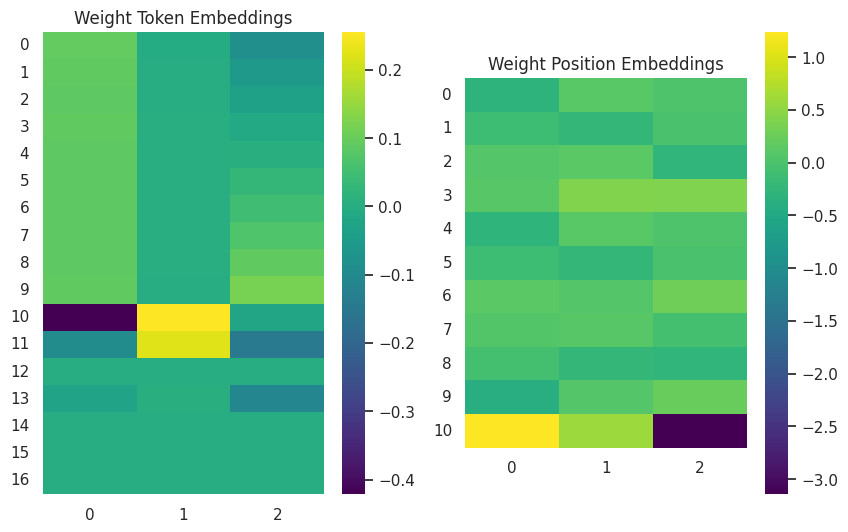

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Weight token embeddings on left plot
sns.heatmap(model.transformer.wte.weight.cpu().detach().numpy(), cmap="viridis", ax=ax[0])
ax[0].set_title("Weight Token Embeddings")

# Weight position embeddings on right plot
sns.heatmap(model.transformer.wpe.weight.cpu().detach().numpy(), cmap="viridis", ax=ax[1])
ax[1].set_title("Weight Position Embeddings")

# Shrink the second plot's height
pos = ax[1].get_position()
ax[1].set_position([pos.x0, pos.y0 + pos.height * 0.1, pos.width, pos.height * 0.8])

ax[0].tick_params(axis='y', rotation=0)
ax[1].tick_params(axis='y', rotation=0)

In [7]:
prompt = input()

In [9]:
tokens = model.tokenizer(
        prompt, 
        return_tensors="pt", 
        padding='max_length', 
        max_length=8, #e.g. 191+406=
        padding_side="left"
        )["input_ids"].to(model.device)
print(prompt)
print(tokens)

13+64=
tensor([[13, 13,  1,  3, 10,  6,  4, 11]], device='cuda:0')


In [16]:
tok_emb = model.transformer.wte(tokens).to("cpu").detach().numpy()

In [17]:
# Quick example: token embeddings as 3D points
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d(x=tok_emb[:,0], y=tok_emb[:,1], z=tok_emb[:,2], 
                                    mode='markers+text', text=tokens.to("cpu").detach().numpy())])

In [18]:
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers+text',
              'text': {'bdata': ('AAAAAAAAKkAAAAAAAAAqQAAAAAAAAP' ... 'AAABhAAAAAAAAAEEAAAAAAAAAmQA=='),
                       'dtype': 'f8',
                       'shape': '1, 8'},
              'type': 'scatter3d',
              'x': {'bdata': 'PkDjvB+EmzubCOG9', 'dtype': 'f4', 'shape': '1, 3'},
              'y': {'bdata': 'PkDjvB+EmzubCOG9', 'dtype': 'f4', 'shape': '1, 3'},
              'z': {'bdata': 'jqG3PUFLx7mZymq9', 'dtype': 'f4', 'shape': '1, 3'}}],
    'layout': {'template': '...'}
})